--To predict the house price of future months

In [25]:
require 'torch'
require 'nn'
require 'optim'
require 'gnuplot'

In [26]:
month = torch.range(1,10)
price = torch.Tensor{28993,29110,29436,30791,33384,36762,39900,39972,40230,40146}

In [27]:
model = nn.Sequential()
model:add(nn.MulConstant(0.1))
model:add(nn.Linear(1,3))
model:add(nn.Sigmoid())
model:add(nn.Linear(3,3))
model:add(nn.Sigmoid())
model:add(nn.Linear(3,1))
model:add(nn.MulConstant(50000))
criterion = nn.MSECriterion()

In [28]:
month_train = month:reshape(10,1)
price_train = price:reshape(10,1)

In [29]:
gnuplot.figure()
w, dl_dw = model:getParameters()

In [30]:
feval = function(w_new)
   if w ~= w_new then w:copy(w_new) end
    dl_dw:zero()

    price_predict = model:forward(month_train)
    loss = criterion:forward(price_predict, price_train)
    model:backward(month_train, criterion:backward(price_predict, price_train))
    return loss, dl_dw
end

In [31]:
params = {
   learningRate = 1e-2
}

In [38]:
for i=1,3000 do
   optim.rprop(feval, w, params)

   if i%10==0 then
      gnuplot.plot({month, price}, {month_train:reshape(10), price_predict:reshape(10)})
   end
end

In [41]:
month_predict = torch.range(1,12)
price_predict = model:forward(month_predict:reshape(12,1))
print(price_predict)

--gnuplot.pngfigure('plot.png')
gnuplot.figure()
gnuplot.plot({month, price}, {month_predict, price_predict})
--gnuplot.plotflush()

 29030.3408
 29040.7993
 29460.8121
 30830.0846
 33328.6767
 36823.0442
 39753.8486
 40189.3112
 40157.7707
 40114.6299
 40088.0370
 40071.7780
[torch.DoubleTensor of size 12x1]



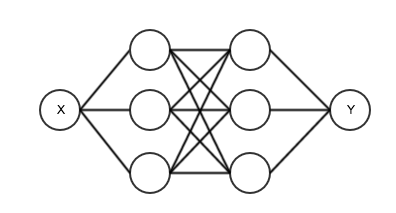

In [40]:
itorch.image('mlp.png')

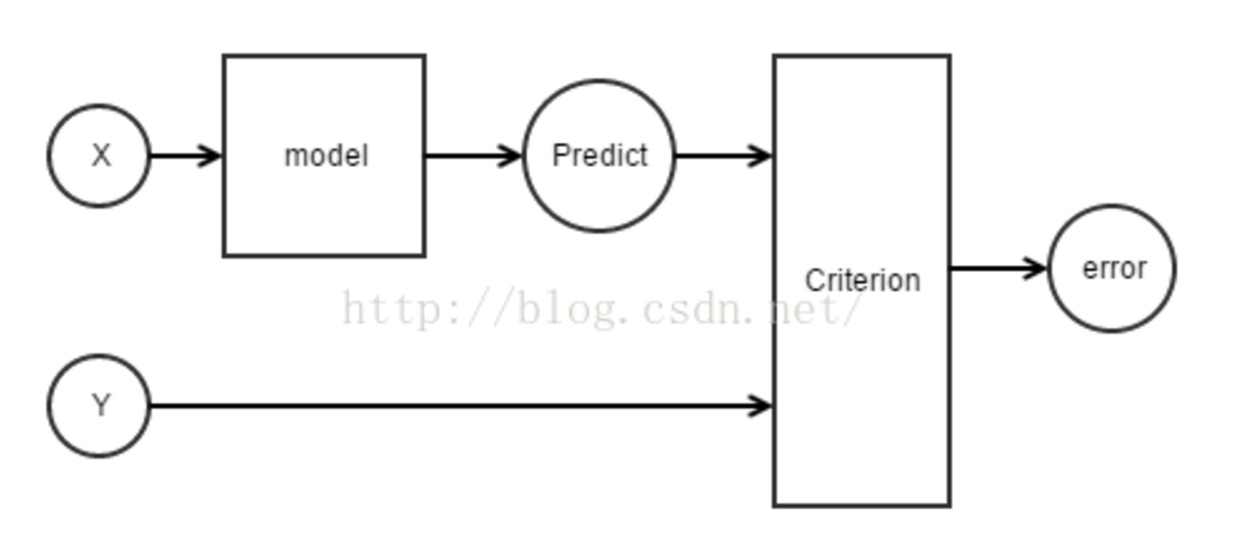

In [5]:
itorch.image('forward')

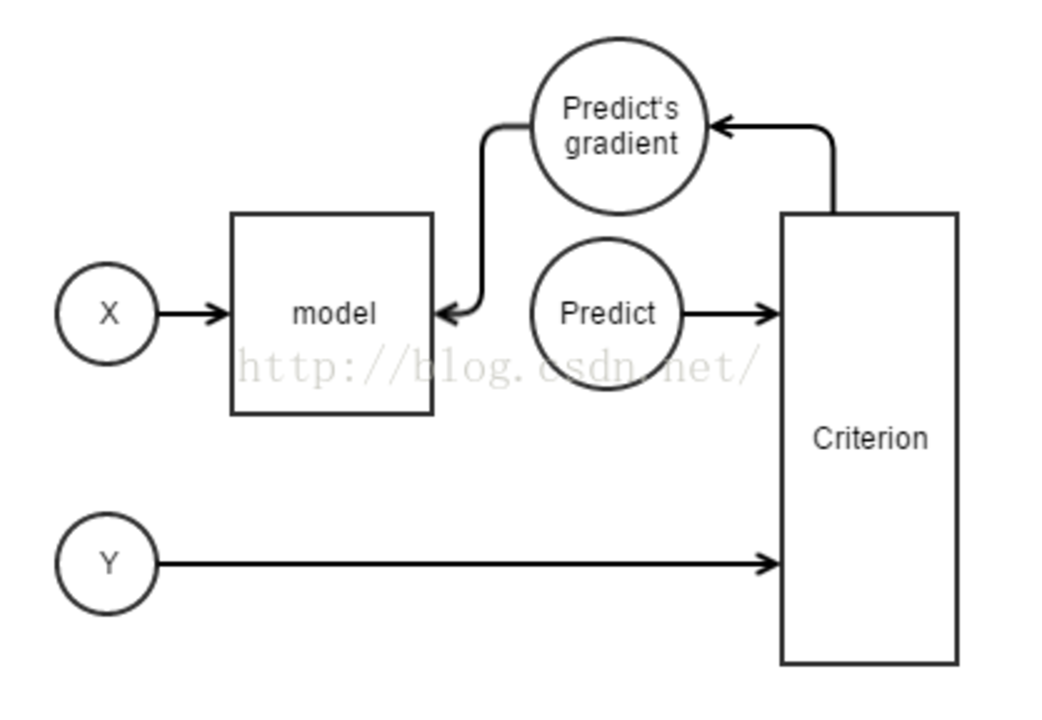

In [19]:
itorch.image('backward')

--To recognize the handwritten digits in the MNIST handwritten digits database

In [42]:
require 'torch'
require 'nn'
require 'optim'
--require 'cunn'
--require 'cutorch'
mnist = require 'mnist'

In [43]:
fullset = mnist.traindataset()
testset = mnist.testdataset()

trainset = {
    size = 50000,
    data = fullset.data[{{1,50000}}]:double(),
    label = fullset.label[{{1,50000}}]
}

validationset = {
    size = 10000,
    data = fullset.data[{{50001,60000}}]:double(),
    label = fullset.label[{{50001,60000}}]
}

trainset.data = trainset.data - trainset.data:mean()
validationset.data = validationset.data - validationset.data:mean()

In [44]:
local recurrentFeatures = 20
local convolutionFeatures = 50
model = nn.Sequential()
model:add(nn.Reshape(1, 28, 28))
model:add(nn.MulConstant(1/256.0*3.2))
model:add(nn.SpatialConvolutionMM(1, convolutionFeatures, 5, 5, 1, 1, 0, 0))
model:add(nn.SpatialMaxPooling(2, 2 , 2, 2, 0, 0))
model:add(nn.SpatialConvolutionMM(convolutionFeatures, recurrentFeatures, 5, 5, 1, 1, 0, 0))
model:add(nn.SpatialMaxPooling(2, 2 , 2, 2, 0, 0))
model:add(nn.Reshape(4*4*recurrentFeatures))
model:add(nn.Linear(4*4*recurrentFeatures, 500))
model:add(nn.ReLU())
model:add(nn.Linear(500, 10))
model:add(nn.LogSoftMax())

model = require('weight-init')(model, 'xavier')

criterion = nn.ClassNLLCriterion()

In [45]:
sgd_params = {
   learningRate = 1e-2,
   learningRateDecay = 1e-4,
   weightDecay = 1e-3,
   momentum = 1e-4
}

x, dl_dx = model:getParameters()

In [46]:
step = function(batch_size)
    local current_loss = 0
    local count = 0
    local shuffle = torch.randperm(trainset.size)
    batch_size = batch_size or 200
    for t = 1,trainset.size,batch_size do
        -- setup inputs and targets for this mini-batch
        local size = math.min(t + batch_size - 1, trainset.size) - t
        local inputs = torch.Tensor(size, 28, 28)--:cuda()
        local targets = torch.Tensor(size)--:cuda()
        local startTime = torch.tic()
        for i = 1,size do
            local input = trainset.data[shuffle[i+t]]
            local target = trainset.label[shuffle[i+t]]
            -- if target == 0 then target = 10 end
            inputs[i] = input
            targets[i] = target
        end

        targets:add(1)
        local feval = function(x_new)
            -- reset data
            if x ~= x_new then x:copy(x_new) end
            dl_dx:zero()

            -- perform mini-batch gradient descent
            local loss = criterion:forward(model:forward(inputs), targets)
            model:backward(inputs, criterion:backward(model.output, targets))

            return loss, dl_dx
        end

        _, fs = optim.sgd(feval, x, sgd_params)

        -- fs is a table containing value of the loss function
        -- (just 1 value for the SGD optimization)
        count = count + 1
        current_loss = current_loss + fs[1]
    end

    -- normalize loss
    return current_loss / count
end

In [47]:
eval = function(dataset, batch_size)
    local count = 0
    batch_size = batch_size or 200
    
    for i = 1,dataset.size,batch_size do
        local size = math.min(i + batch_size - 1, dataset.size) - i
        local inputs = dataset.data[{{i,i+size-1}}]--:cuda()
        local targets = dataset.label[{{i,i+size-1}}]:long()--:cuda()
        local outputs = model:forward(inputs)
        local _, indices = torch.max(outputs, 2)
        indices:add(-1)
        local guessed_right = indices:eq(targets):sum()
        count = count + guessed_right
    end

    return count / dataset.size
end

In [48]:
max_iters = 5

do
    local last_accuracy = 0
    local decreasing = 0
    local threshold = 1 -- how many deacreasing epochs we allow
    local startTime = torch.tic()
    for i = 1,max_iters do
        local loss = step()
        print(string.format('Epoch: %d Current loss: %4f', i, loss))
        local accuracy = eval(validationset)
        print(string.format('Accuracy on the validation set: %4f', accuracy))
        if accuracy < last_accuracy then
            if decreasing > threshold then break end
            decreasing = decreasing + 1
        else
            decreasing = 0
        end
        last_accuracy = accuracy
    end
    local durationSeconds = torch.toc(startTime)
    print(string.format("time cost: %.2f seconds", durationSeconds))
end

Epoch: 1 Current loss: 0.743697	


Accuracy on the validation set: 0.913500	


Epoch: 2 Current loss: 0.253361	


Accuracy on the validation set: 0.938400	


Epoch: 3 Current loss: 0.184530	


Accuracy on the validation set: 0.954600	


Epoch: 4 Current loss: 0.148566	


Accuracy on the validation set: 0.960000	


Epoch: 5 Current loss: 0.124539	


Accuracy on the validation set: 0.963200	
time cost: 396.29 seconds	


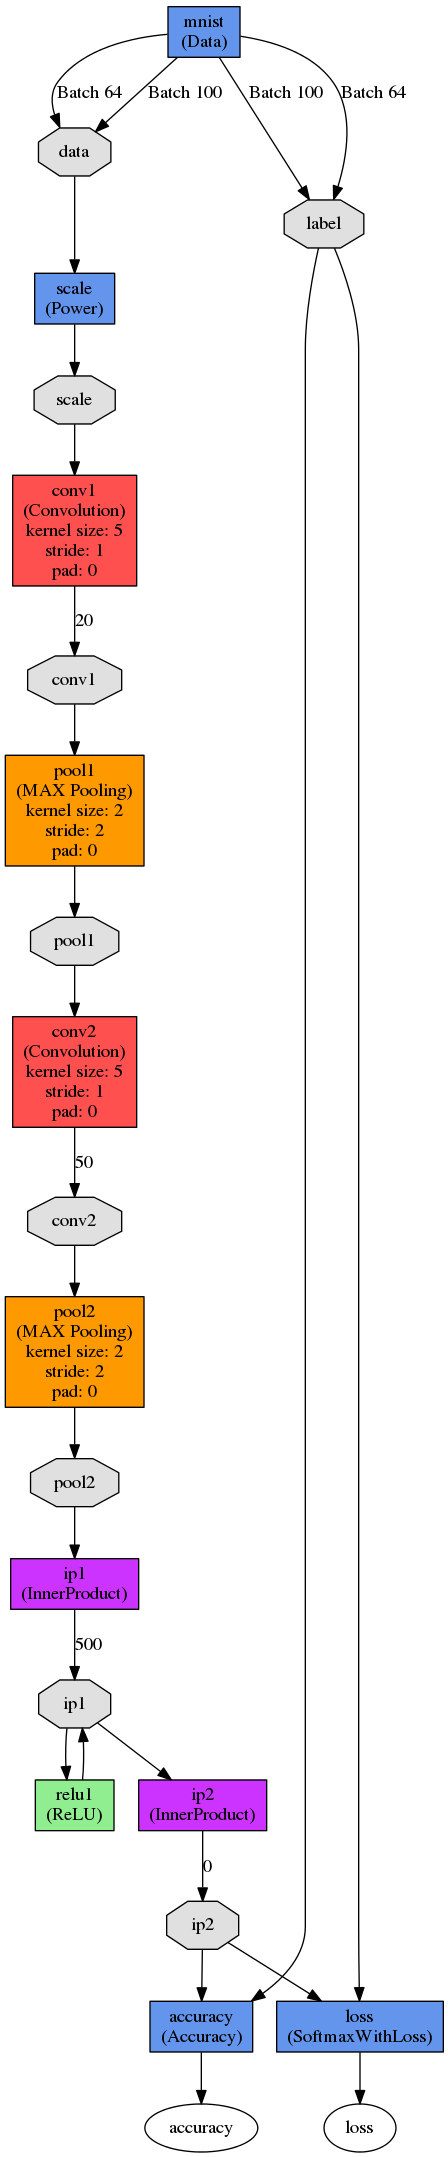

In [15]:
itorch.image('lenet.png')

==> processing options	
==> downloading dataset	


==> using reduced training data, for fast experiments	
==> loading dataset	


==> preprocessing data	


==> preprocessing data: colorspace RGB -> YUV	


==> preprocessing data: normalize each feature (channel) globally	


==> preprocessing data: normalize all three channels locally	


==> verify statistics	


training data, y-channel, mean: -0.006313964130324	
training data, y-channel, standard deviation: 0.94085703702485	
test data, y-channel, mean: 0.064013399412288	
test data, y-channel, standard deviation: 1.071276998706	


training data, u-channel, mean: 0.21264134455774	
training data, u-channel, standard deviation: 0.78796429042957	
test data, u-channel, mean: 0.26287914265976	
test data, u-channel, standard deviation: 0.91655089439651	


training data, v-channel, mean: 0.22919727583664	
training data, v-channel, standard deviation: 0.74868942342819	
test data, v-channel, mean: 0.23141433715934	
test data, v-channel, standard deviation: 0.89402614301349	
==> visualizing data	


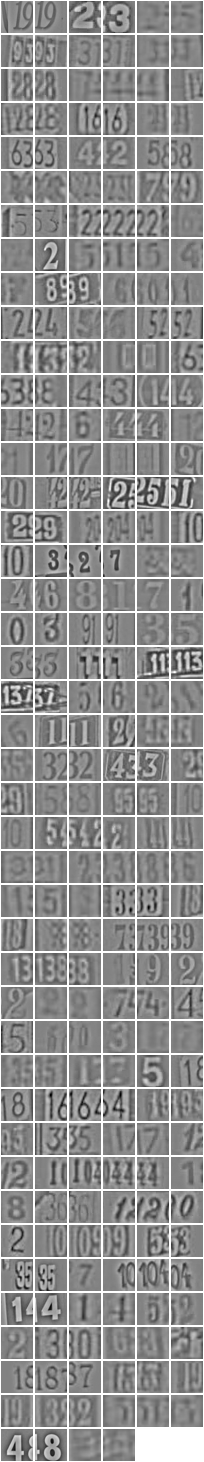

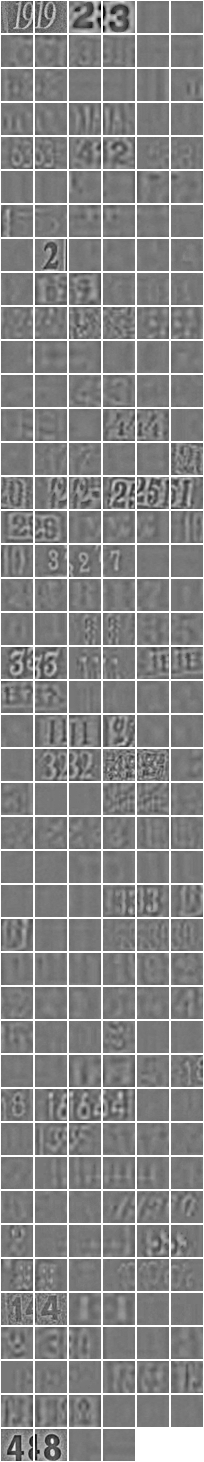

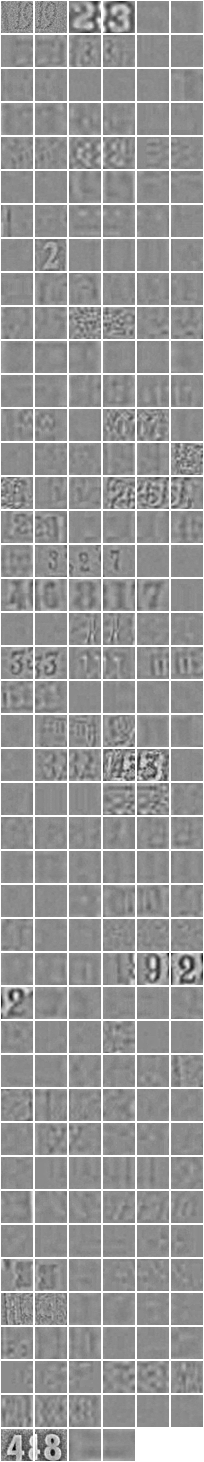

In [2]:
dofile('1_data.lua')